# Kinetic Theory of Gases

In your lab you made a simulation of a gas of hard discs bouncing around in a billiard.  From an algorithm standpoint, you learned about event driven simulations, and some of the tricks of making these efficient.

Today we will discuss some of the physics around this system.  It is one of the iconic many-body systems, which is used to think about many physical processes.

## Boltzmann distribution

The first thing that we saw in this simulation is that after a few collsions, the state of the system was essentially random.  It is chaotic, and small changes in initial conditions lead to completely different configurations later.  Thus we are naturally led to a statistical description of the system.  For example, if you look at a random frame of the simulation, and look at the speed of one of the particles, what distribution do you expect the speed to be drawn from?

The generic argument here starts with the premise of *ergodicity*.  We posit that things are so random that any state of the system, consistent with the conservation laws, is equally likely.  Thus if we had 1 particle, it will have a random velocity whose magnitude is fixed, but whose direction is uniformly distributed.  With 2 particles, $v_{x1},v_{x2},v_{y1},v_{y2}$ are uniformly distributed with the constraint that $v_{x1}^2+v_{x2}^2+v_{y1}^2+v_{y2}^2$ is fixed.  In the limit of a large number of particles this leads to a universal result.

Working with continuous probability distributions is a bit of a pain, so lets imagine that we discretize velocity-space.  We define $\Omega(N,E)$ be the number of ways of choosing the velocities of $N$ particles, such that the total energy is $E$.

Lets now consider a system of $N+1$ particles.  We want to know what the probability that the extra particles has velocity $\vec v$.  To find that, we just count how many ways of arranging all of the other particles:
\begin{equation}
P(\vec{v})=\frac{\Omega(N,E-\epsilon_v)}{\Omega(N+1,E)}
\end{equation}
here $\epsilon_v=mv^2/2$ is the energy of the particle we are caring about.

The next stage of the argument is to note that $\Omega$ is exponentially big in $N$.  Thus it is natural to write
\begin{equation}
\Omega(N,E-\epsilon_v)=e^{k_B S(N,E-\epsilon_v)}
\end{equation}
where $S$ should be proportional to $N$.  We call $S$ the entropy.  The factor of $k_B$ is just convention -- it gives the units of $S$.  The only physical quantity is $k_B S$.  I often take $k_B=1$.

Next we note that generically $\epsilon_v\ll E$,
so we can Taylor expand,
\begin{equation}
S(N,E-\epsilon_v)\approx S(N,E)-\epsilon_V \frac{\partial S(N,E)}{\partial E}
\end{equation}
The derivative $\partial S/\partial E$ is some function of $N$ and $E$.  We want to give this function a name.  By convention, we define
\begin{equation}
\frac{\partial S(N,E)}{\partial E}= \frac{1}{T(N,E)}
\end{equation}
where the function $T(N,E)$ is known as the temperature.  

Putting this together, we have 
\begin{equation}
P(\vec{v})\propto e^{-\frac{\epsilon_v}{k_B T}},
\end{equation}
which is known as the Boltzmann distribution.  To find the distribution for the speed, we note that 
\begin{align}
P(|v|)&= \int \!\!d^2{\vec{v}^\prime}\,P(\vec{v}^\prime)\,\delta(|v|-|\vec{v}^\prime|)\\
&\propto v e^{-\frac{mv^2}{2k_B T}}.
\end{align}
As a final step we normalize the distribution by noting that the total probability is equal to 1,
\begin{align}
\int_0^\infty \!\!dv\,v e^{-\frac{mv^2}{2k_B T}}
&=\int_0^\infty \!\!\frac{dv^2}{2} e^{-\frac{mv^2}{2k_B T}}\\
&= \frac{k_B T}{m}
\end{align}
and hence
\begin{equation}
P(|v|)= \frac{m v}{k_B T} e^{-\frac{mv^2}{2k_B T}}.
\end{equation}

Note, this result depends on dimension -- so the 3D results look slightly different.

In [1]:
using Plots,Logging,ProgressMeter,LinearAlgebra,LaTeXStrings

abstract type Event end

struct NullEvent <: Event
    t ::Float64
end

NE=NullEvent(Inf)

mutable struct Ball
    x ::Float64
    y ::Float64
    vx ::Float64
    vy ::Float64
    radius ::Float64
    nextevent ::Event
end

function set_xv!(ball ::Ball,xy,vxy)
    ball.x,ball.y=xy
    ball.vx,ball.vy=vxy
    return ball
end

function set_r!(ball ::Ball,x,y)
    ball.x=x
    ball.y=y
    return ball
end

function set_r!(ball ::Ball,r)
    ball.x,ball.y=r
    return ball
end

function set_v!(ball ::Ball,v)
    ball.vx,ball.vy=v
    return ball
end

function set_v!(ball ::Ball,vx,vy)
    ball.vx=vx
    ball.vy=vy
    return ball
end

function get_r(ball ::Ball)
    return [ball.x,ball.y]
end

function get_v(ball ::Ball)
    return [ball.vx,ball.vy]
end


Base.show(io::IO,b::Ball)=print(io,
    "Ball << r="*repr((b.x,b.y))*
    " v="*repr((b.vx,b.vy))*">>)")

Ball(;x,y,vx,vy,radius,nextevent=NE)=Ball(x,y,vx,vy,radius,nextevent) # keyword constructor
function Ball(r,v,radius,nextevent=NE) # constructor using containers
    x,y=r
    vx,vy=v
    Ball(x,y,vx,vy,radius,nextevent)
end
Ball(;r,v,radius,nextevent=NE)=Ball(r,v,radius,nextevent) # keyword constructor using containers

abstract type Wall end

struct Hwall <: Wall
    y ::Float64
end

struct Vwall <: Wall
    x ::Float64
end

function impact_time(w::Hwall,b::Ball,t)
    dy=w.y-b.y
    return (dy-sign(b.vy)*b.radius)/b.vy+t
end

function impact_time(w::Vwall,b::Ball,t)
    dx=w.x-b.x
    return (dx-sign(b.vx)*b.radius)/b.vx+t
end

impact_time(b::Ball,w::Wall,t)=impact_time(w,b,t)

function circ_time(r0,v,r)
    # Calculate the various terms in our expression
    r0dotv=r0⋅v
    if r0dotv>0 #moving away from one another
        return Inf
    end
    vsq=v⋅v
    r0sq=r0⋅r0
    if r0sq<=r^2 #balls are interpenetrating
        return Inf
    end
    discriminant=r0dotv^2+(r^2-r0sq)*vsq  
    if discriminant<0 # balls will never hit one-another
        return Inf
    end
    times=[(-r0dotv-sqrt(discriminant))/(vsq),(-r0dotv+sqrt(discriminant))/(vsq)]
    t1,t2=minmax(times...)
    if t2<=0
        return Inf
    end
    if t1>0
        return t1
    end
    return t2
end

impact_time(b1::Ball,b2::Ball,t)=
    t+circ_time(get_r(b1)-get_r(b2),
        get_v(b1)-get_v(b2),b1.radius+b2.radius)


struct Collision <: Event
    object1 :: Union{Ball,Wall}
    object2 :: Union{Ball,Wall}
    t  ::Float64     
end

mutable struct Billiard
    walls ::Array{Wall}
    balls ::Array{Ball}
    t ::Float64
    nextevent ::Event
    boundingbox ::Array{Float64,1}# x1,y1,x2,y2 = corners of a rectangle
end

Billiard(;walls,balls,t=0.,nextevent=NE,boundingbox)=
    Billiard(walls,balls,t,nextevent,boundingbox)

function next_event(b::Ball,billiard::Billiard)
    t=billiard.t
    t_event=Inf
    result=NE
    for obj in union(billiard.balls,billiard.walls)
        t_try=impact_time(b,obj,t)
        if t_try<t_event && t_try>t
            t_event=t_try
            result=Collision(b,obj,t_try)
        end
    end
    return result
end

function drawcircles!(centers,radii;opts...)
    c=[cos(θ) for θ in 0:2*pi/100:2pi]
    s=[sin(θ) for θ in 0:2*pi/100:2pi]
    makecircle(center,radius)=Shape(radius*c.+center[1],radius*s.+center[2])
    circles=[makecircle(c,r) for (c,r) in zip(centers,radii)]
    plot!(circles;aspect_ratio=:equal,label="",opts...)
end

function drawcircles!(plt::Plots.Plot,centers,radii;opts...)
    c=[cos(θ) for θ in 0:2*pi/100:2pi]
    s=[sin(θ) for θ in 0:2*pi/100:2pi]
    makecircle(center,radius)=Shape(radius*c.+center[1],radius*s.+center[2])
    circles=[makecircle(c,r) for (c,r) in zip(centers,radii)]
    plot!(plt,circles;aspect_ratio=:equal,label="",opts...)
end

function drawcircles(centers,radii;opts...)
    plt=plot()
    drawcircles!(plt,centers,radii;opts...)
end

# Master function for visualizing
# -- creates new plot object, and then calls visualize!
function visualize(opts...;namedopts...)
    viz=plot()
    visualize!(viz,opts...;namedopts...)
    return viz
end

function visualize!(viz::Plots.Plot,w::Hwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    y=w.y
    plot!(viz,[x1,x2],[y,y];opts...)
end

function visualize!(viz::Plots.Plot,w::Vwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    x=w.x
    plot!(viz,[x,x],[y1,y2];opts...)
end

function visualize!(viz::Plots.Plot,b::Billiard;wallopts=[],ballopts=[])
    walls=b.walls
    balls=b.balls
    bbox=b.boundingbox
    for w in walls
        visualize!(viz,w,bbox;label="",wallopts...)
    end
    centers=[(b.x,b.y) for b in balls]
    radii=[b.radius for b in balls]
    drawcircles!(viz,centers,radii;ballopts...)
    return viz
end

function setevents!(billiard::Billiard)
    t_global=Inf
    for b in billiard.balls
        next=next_event(b,billiard)
        b.nextevent=next
        if next.t<t_global
            t_global=next.t
            billiard.nextevent=next
        end
    end
    return billiard
end

reflect(vec,normal)=vec-2*(vec⋅normal)*normal/(normal⋅normal)
normal(w::Hwall,r)=[0,1]
normal(w::Vwall,r)=[1,0]

function newvelocity(w::Wall,b::Ball)
    r=get_r(b)
    n=normal(w,r)
    v=get_v(b)
    return reflect(v,n)
end

function set_newvelocity!(w::Wall,b::Ball)
    v=newvelocity(w,b)
    set_v!(b,v)
    return b
end

set_newvelocity!(b::Ball,w::Wall)=set_newvelocity!(w,b)

function set_newvelocity!(b1::Ball,b2::Ball)
    r1=get_r(b1)
    r2=get_r(b2)
    v1=get_v(b1)
    v2=get_v(b2)
    norm=r1-r2
    vcm=(v1+v2)/2
    r12=r1-r2
    newv1=reflect(v1-vcm,r12)+vcm
    newv2=reflect(v2-vcm,r12)+vcm
    set_v!(b1,newv1)
    set_v!(b2,newv2)
    return (newv1,newv2)
end

function time_evolve!(b::Ball,dt)
    r=get_r(b)
    v=get_v(b)
    newr=r+v*dt
    set_r!(b,newr)
end
    
function update!(billiard::Billiard,event::Event)
    dt=event.t-billiard.t
    for b in billiard.balls
        time_evolve!(b,dt)
    end
    set_newvelocity!(event.object1,event.object2)
    billiard.t=event.t
    return billiard
end

struct State
    xvalues ::Array{Float64,1}
    yvalues ::Array{Float64,1}
    vxvalues ::Array{Float64,1}
    vyvalues ::Array{Float64,1}
    radii ::Array{Float64,1}
    t ::Float64
end

struct Simulationdata
    walls :: Array{Wall}
    statelist :: Array{State}
    boundingbox ::Array{Float64,1}
end

Base.length(s::Simulationdata)=length(s.statelist)

function State(b::Billiard)
    xvalues = [ball.x for ball in b.balls]
    yvalues = [ball.y for ball in b.balls]
    vxvalues = [ball.vx for ball in b.balls]
    vyvalues = [ball.vy for ball in b.balls]
    radii = [ball.radius for ball in b.balls]
    t=b.t
    State(xvalues,yvalues,vxvalues,vyvalues,radii,t)
end




function randomgrid(nx,ny,r,Lx,Ly)
    xstep=Lx/nx
    ystep=Ly/ny
    function randomball(x,y)
        θ=2*pi*rand()
        Ball((x,y),(cos(θ),sin(θ)),r)
    end
    Billiard([Hwall(Ly/2),Hwall(-Ly/2),Vwall(Lx/2),Vwall(-Lx/2)],
        [randomball(x,y) 
                for x in -Lx/2+xstep/2:xstep:Lx/2-xstep/2 
                for y in -Ly/2+ystep/2:ystep:Ly/2-ystep/2],
        0., NE,[-Lx/2,-Ly/2,Lx/2,Ly/2])
end

randomgrid(;nx,ny,r,Lx,Ly)=randomgrid(nx,ny,r,Lx,Ly)

function setevents!(billiard::Billiard,lastevent::Collision)
    # The first thing we do is make a list of all the `Ball` 
    # objects in `lastevent`.  We store this in `cballs
    cballs=Ball[]
    if typeof(lastevent.object1)==Ball
        push!(cballs,lastevent.object1)
    end
    if typeof(lastevent.object2)==Ball
        push!(cballs,lastevent.object2)
    end
    # Next unpack the data from `billiard`
    balls=billiard.balls
    walls=billiard.walls
    t=billiard.t
    # set null events for unknown collisions
    billiard.nextevent=NE
    for cb in cballs
        cb.nextevent=NE
    end
    # Loop over balls
    for b in balls 
        for cb in cballs
            ct=impact_time(b,cb,t) 
            if ct<=t ;continue; end
            if ct<b.nextevent.t 
                b.nextevent=Collision(b,cb,ct)
            end
            if ct<cb.nextevent.t
                cb.nextevent=Collision(b,cb,ct)
            end
            if ct<billiard.nextevent.t
                billiard.nextevent=Collision(b,cb,ct)
            end
            if b.nextevent.t<billiard.nextevent.t
                billiard.nextevent=b.nextevent
            end
        end
    end
    # loop over walls
    for w in walls
        for cb in cballs
            ct=impact_time(w,cb,t)
            if ct<=t
                continue 
            end
            if ct<cb.nextevent.t
                cb.nextevent=Collision(w,cb,ct)
            end
            if ct<billiard.nextevent.t
                billiard.nextevent=Collision(w,cb,ct)
            end
        end
    end
    return billiard
end

function simulate(billiard::Billiard,n)
    result=Array{State}(undef,n+1)
    result[1]=State(billiard)
    setevents!(billiard)
    for j in 2:n+1
        setevents!(billiard,billiard.nextevent)
        update!(billiard,billiard.nextevent)
        result[j]=State(billiard)
    end
    return Simulationdata(billiard.walls,result,billiard.boundingbox)
end

"""
    speedlist(sim::Simulationdata,frame::Integer)

Makes a list of the speeds of all of the particles in frame number 
`frame` of the simulation data.  You can also call it with a list of
frames and it will concatentate those lists.

For example, you can call with

    speedlist(s,[1,3,5])

and get the speeds in frames 1, 3, 5.  We can even use

    speedlist(s,1::10::100)

which will do every 10'th frame between 1 and 100.
"""
speedlist(sim::Simulationdata,frame::Integer) =
    sqrt.(sim.statelist[frame].vxvalues.^2
            +sim.statelist[frame].vyvalues.^2)

speedlist(sim::Simulationdata,frames)=
    vcat([speedlist(sim,j) for j in frames]...)

# Visualization


function drawcircles!(plt::Plots.Plot,xvalues,yvalues,radii;opts...)
    c=[cos(θ) for θ in 0:2*pi/100:2pi]
    s=[sin(θ) for θ in 0:2*pi/100:2pi]
    makecircle(x,y,radius)=Shape(radius*c.+x,radius*s.+y)
    circles=[makecircle(x,y,r) for (x,y,r) in zip(xvalues,yvalues,radii)]
    plot!(plt,circles;aspect_ratio=:equal,label="",opts...)
end

function visualize!(plt::Plots.Plot,s::State;opts...)
    drawcircles!(plt,s.xvalues,s.yvalues,s.radii;opts...)
end

function drawframe(s::Simulationdata,j)
    walls=s.walls
    bbox=s.boundingbox
    plt=plot()
    for w in walls
        visualize!(plt,w,bbox;label="")
    end
    visualize!(plt,s.statelist[j])
end

#
#
# function eventanimate(s::Simulationdata,skip=1)
#     # print out a message to let the user know things are starting
#     @info "Animating Simulation"
#     len=length(s)
#     progress_meter=Progress(len,desc="Generating frames: ")
#     anim =  @animate for i in 1:skip:len
#         ProgressMeter.update!(progress_meter,i)
#         drawframe(s,i)
#     end
#     Plots.gif(anim, fps = 12)
# end

drawframe (generic function with 1 method)

While the `Plots.jl` visualizations work, they are kind of slow.  Here is a quick `GLMakie` script to animate the `Simulationdata`

In [56]:
using GLMakie

function drawcircles!(ax::Axis,centers,radii;opts...)
    circles=[Circle(Point2f(c),r) for (c,r) in zip(centers,radii)]
    poly!(ax,circles;opts...)
end

function drawcircles!(plt::Axis,xvalues,yvalues,radii;opts...)
    circles=[Circle(Point2f(x,y),r) for (x,y,r) in zip(xvalues,yvalues,radii)]
    poly!(plt,circles;opts...)
end

function newplot()
    f=Figure()
    ax=Axis(f[1,1],aspect=1.0)
    display(f)
    return f,ax
end

function visualize!(viz::Axis,w::Hwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    y=w.y
    lines!(viz,[x1,x2],[y,y];opts...)
end

function visualize!(viz::Axis,w::Vwall,bbox;opts...)
    x1,y1,x2,y2=bbox
    x=w.x
    lines!(viz,[x,x],[y1,y2];opts...)
end

function visualize!(viz::Axis,b::Billiard;wallopts=[],ballopts=[])
    walls=b.walls
    balls=b.balls
    bbox=b.boundingbox
    for w in walls
        visualize!(viz,w,bbox;label="",wallopts...)
    end
    centers=[Point2f(b.x,b.y) for b in balls]
    radii=[b.radius for b in balls]
    drawcircles!(viz,centers,radii;ballopts...)
    return viz
end

function setcircles!(circles,centers,radii)
    for j in eachindex(circles)
        circles[j]=Circle(Point2f(centers[j]),radii[j])
    end
end

function setcircles!(circles,xs,ys,radii)
    for j in eachindex(circles)
        circles[j]=Circle(Point2f(xs[j],ys[j]),radii[j])
    end
end

setcircles(centers,radii)=[Circle(Point2f(c),r) for (c,r) in zip(centers,radii)]

setcircles(xs,ys,radii)=[Circle(Point2f(x,y),r) for (x,y,r) in zip(xs,ys,radii)]


function eventanimate(s::Simulationdata,timestep=0.001)
    # Create Plot
    f,ax=newplot()
    Makie.deactivate_interaction!(ax, :rectanglezoom)
    # Draw Walls
    for w in s.walls
        visualize!(ax,w,s.boundingbox)
    end
    #Draw Circles
    state=s.statelist[1]
    circles=setcircles(state.xvalues,state.yvalues,state.radii)
    obscircles=Observable(circles)
    poly!(ax,obscircles)
    # Create Slider
    controls=Slider(f[2,1],range=1:1:length(s.statelist),startvalue=1)
    on(controls.value) do j
        state=s.statelist[j]
        setcircles!(circles,state.xvalues,state.yvalues,state.radii)
        notify(obscircles)
    end
    # Create Run button
    isrunning = Observable(false)
    label = map(cond -> cond ? "Stop" : "Run", isrunning)
    run = Button(f[3,1]; label = label, tellwidth = false)
    on(run.clicks) do clicks
        isrunning[] = !isrunning[] 
    end
    isrunning_notifier = Condition()
    on(cond -> cond && notify(isrunning_notifier), isrunning)
    errormonitor(@async while true
        if isrunning[]
            maxj=controls.range[][end]
            while controls.value[]==maxj
                isrunning[]=false
                wait(isrunning_notifier)
            end
            isopen(f.scene) || break # stops if window is closed
            j=controls.value[]
            set_close_to!(controls,j+1)
            sleep(timestep)
        else
            wait(isrunning_notifier)
        end
    end)
end

# Make Plots the default package for some of the 
# typical commands
scatter=Plots.scatter
scatter! =Plots.scatter!
heatmap=Plots.heatmap
heatmap! =Plots.heatmap!
plot=Plots.plot
plot! =Plots.plot!

plot! (generic function with 4 methods)

## Running the simulations

Lets start with a random grid of 100 particles.

It is useful to name our variables in such a way that we can figure out what parameters they correspond to.

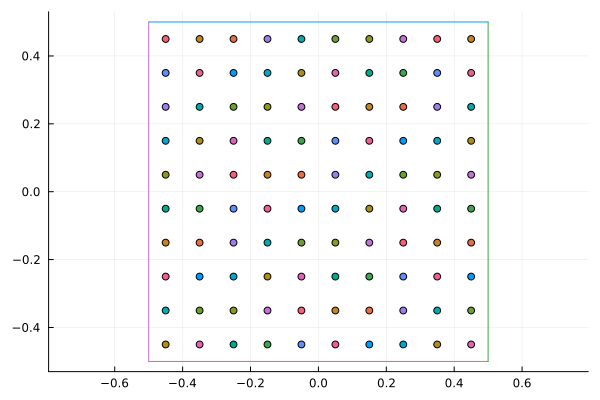

In [8]:
g_N100_r01=randomgrid(nx=10,ny=10,r=0.01,Lx=1,Ly=1)
visualize(g_N100_r01)

In [9]:
g_N100_r01.balls

100-element Vector{Ball}:
 Ball << r=(-0.45, -0.45) v=(0.2932363813898115, 0.9560399702049119)>>)
 Ball << r=(-0.45, -0.35) v=(0.06879322667868792, 0.997630939758353)>>)
 Ball << r=(-0.45, -0.25) v=(-0.9284114029347061, 0.37155385464399465)>>)
 Ball << r=(-0.45, -0.15) v=(-0.9133102765271787, 0.4072644580488807)>>)
 Ball << r=(-0.45, -0.05) v=(-0.9078749775596533, 0.4192410107814586)>>)
 Ball << r=(-0.45, 0.05) v=(0.04926548039931171, -0.9987857189813163)>>)
 Ball << r=(-0.45, 0.15) v=(-0.28654094136729946, 0.9580679980671215)>>)
 Ball << r=(-0.45, 0.25) v=(-0.45168434120055084, 0.8921778163091841)>>)
 Ball << r=(-0.45, 0.35) v=(0.38400950268037726, -0.9233291405837732)>>)
 Ball << r=(-0.45, 0.45) v=(0.8717060216085012, -0.4900291949378927)>>)
 Ball << r=(-0.35, -0.45) v=(-0.1515308742306631, 0.9884525249878676)>>)
 Ball << r=(-0.35, -0.35) v=(-0.9575689074569214, 0.28820441959095267)>>)
 Ball << r=(-0.35, -0.25) v=(0.3361176024422644, -0.9418200238519374)>>)
 ⋮
 Ball << r=(0.35, 0.35)

Now lets do a "equilibration" run, where we evolve for enough time for the initial conditions to be forgotten.  Later we will figure out how to determine when things have equilibrated.

  0.676508 seconds (15.27 M allocations: 731.000 MiB, 4.46% gc time, 31.07% compilation time)


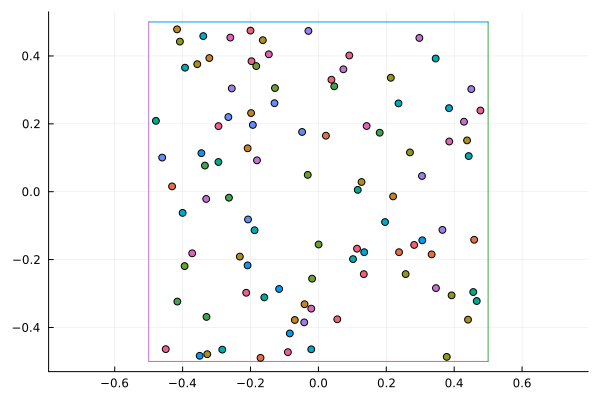

In [10]:
@time s_N100_r01=simulate(g_N100_r01,5000);
visualize(g_N100_r01)

In [61]:
eventanimate(s_N100_r01,0.00001)

Task (runnable) @0x000000037c33bb70

Now we can do a "production" run, where we extract the speeds of the particles after every 50 collisions

  5.279674 seconds (148.77 M allocations: 6.889 GiB, 15.39% gc time)


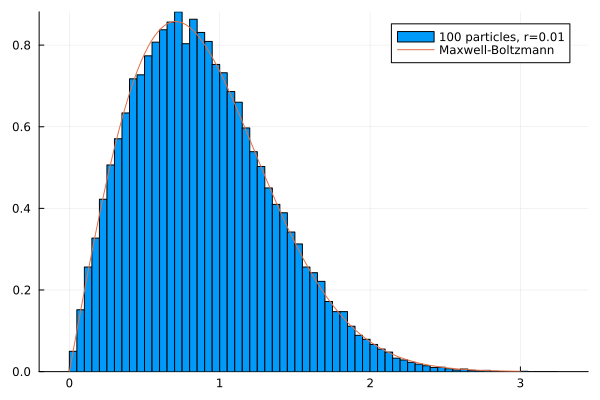

In [12]:
@time sfull_N100_r01=simulate(g_N100_r01,50000);
histogram(speedlist(sfull_N100_r01,1:50:50000),normalize=true,
    label="100 particles, r=0.01")
plot!(v->2*v*exp(-v^2),0,3,label="Maxwell-Boltzmann")

In [51]:
eventanimate(sfull_N100_r01,0.01)

Task (runnable) @0x000000037bf6cb00

max -- waiting
timestep=0.01
max -- waiting
timestep=0.01
max -- waiting


## Correlation time, and correlation functions

To further understand the structures in this gas, it is useful to think about correlations.

We say that random variables $X$ and $Y$ are uncorrelated if the value of $X$ does not depend on the value of y.  For example, here are some uncorrelated random variables


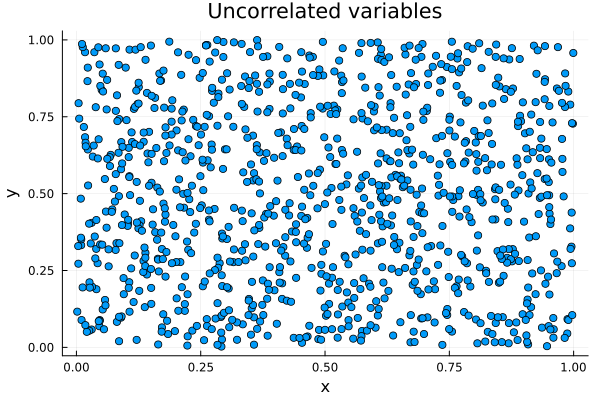

In [14]:
xvals=rand(1000)
yvals=rand(1000)
scatter(xvals,yvals,xlabel="x",ylabel="y",label="",title="Uncorrelated variables")

Here is another, less trivial, uncorrelated example

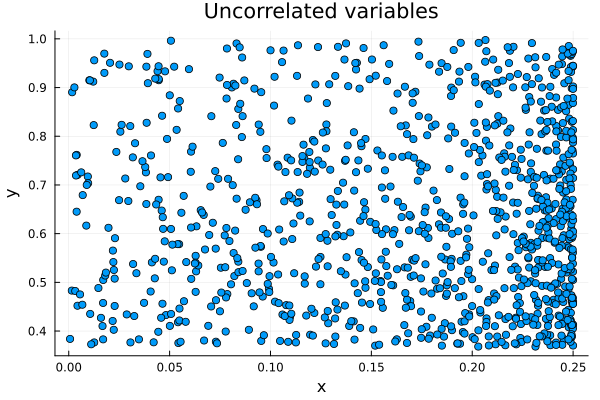

In [15]:
xvals2=xvals.*(1 .-xvals)
yvals2=exp.(-yvals)
scatter(xvals2,yvals2,
    xlabel="x",ylabel="y",label="",title="Uncorrelated variables")

there the x-value and y-value are drawn from non-trivial distributions, but the value of x does not depend on the value of y.

Here is an example of correlated random variables

In [43]:
length(xvals)

1000

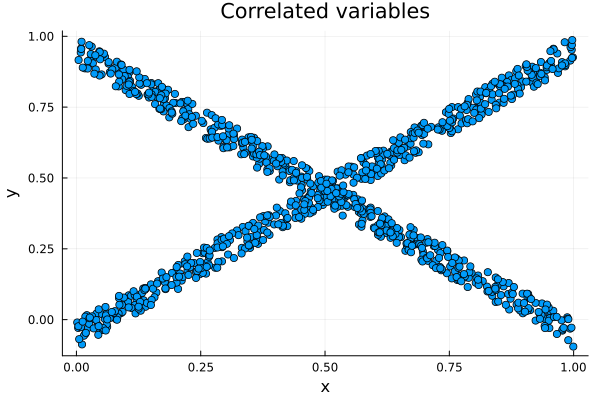

In [47]:
xvals3=xvals
yvals3=vcat((1 .-xvals-0.1*yvals)[1:500],(xvals-0.1*yvals)[501:1000])
scatter(xvals3,yvals3,
    xlabel="x",ylabel="y",label="",title="Correlated variables")

Here the values of $y$ depend on the values of $x$.  

Here is another example:

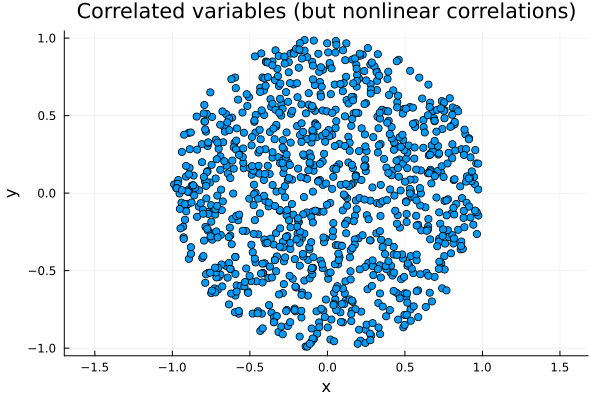

In [17]:
xvals4=@. sqrt(xvals)*cos(2*pi*yvals)
yvals4=@. sqrt(xvals)*sin(2*pi*yvals)
scatter(xvals4,yvals4,
    xlabel="x",ylabel="y",label="",title="Correlated variables (but nonlinear correlations)",aspectratio=1)

One common way to check to see if two random variables are correlated is to calculate the correlation function $\langle XY\rangle-\langle X\rangle \langle Y \rangle$, also referred to as the covariance.

In [18]:
using Statistics
cfun(xvals,yvals)=mean(xvals.*yvals)-mean(xvals)*mean(yvals)

cfun (generic function with 1 method)

In [48]:
@show cfun(xvals,yvals)
@show cfun(xvals2,yvals2)
@show cfun(xvals3,yvals3);

cfun(xvals, yvals) = 0.00017415738923562407
cfun(xvals2, yvals2) = -0.00014915255060880817
cfun(xvals3, yvals3) = 0.0038463327303746575


The correlations in the first two are much smaller than those in the third.  They are non-zero because we are working with a finite sample.   Any particular sample will have some correlations, just by chance.  Later we will work out how large we expect those to be.  One of the primary uses of "statistics" is to determine if the random fluctuations are consistent with uncorrelated noise.

There is a small caution:

In [20]:
@show cfun(xvals4,yvals4);

cfun(xvals4, yvals4) = 0.00505004423000664


Even though `xvals4` and `yvals4` are correlated -- it is a nonlinear form of correlation, which is not diagnosed by the covariance.

Applying this idea to the problem at hand, we might ask how the velocites at two times are related to one-another by calculating $C_{xx}(t,t^\prime)=\langle v_x(t) v_x(t^\prime)\rangle$, and similar expresions for other components.  We don't need to subtract off the mean, since we expect that $\langle v_x(t)\rangle$=0.

Because of reflection invarience, we expect $C_{xy}=0$ and $C_{xx}=C_{yy}$.  Thus the natural quantity to calculate is $C(t,t^\prime)=\langle \vec{v}(t) \cdot\vec{v}(t^\prime)\rangle=C_{xx}+C_{yy}=2 C_{xx}$.  If we are in some sort of steady-state, then it makes sense to average over different times, writing
\begin{equation}
C(\tau)=\frac{1}{T}\int_0^T \langle \vec{v}(t) \cdot\vec{v}(t+\tau)\rangle\,dt.
\end{equation}

The most natural way to calculate this is to first make a time series of the velocities `vlist=[v1,v2,v3,...vT]` where `vj=v(tj)` is a vector of length $2N$ containing the components of the velocity at each time.

Our estimate of $C(\tau=0)$ is
\begin{equation}
C(0)=\frac{1}{TN}(v_1\cdot v_1 + v_2\cdot v_2+\cdots+v_T\cdot v_T)
\end{equation}
Our estimate of $C(\tau=\delta t)$ is
\begin{equation}
C(\delta t)=\frac{1}{(T-1)N}(v_1\cdot v_2 + v_2\cdot v_3+\cdots+V_{T-1}\cdot v_T)
\end{equation}
and so on.

The naive implementation would take a time which scales as $O(N T^2)$.  There are smart ways of doing the convolution which reduce this to $O(N T\log(T))$.  At some point we may talk about that algorithm.  Julia has an implementation of the smart algorithm, which is in the `DSP` package, and called `conv`.  There is also an implementation in the `StatsBase` package, called `autocov`, which I believe is just the naive algorithm (written in a pretty nice way).

Lets just write our own.

The first thing we need is the time-series data of the velocities.  We could either modify our simulation code to extract that, or we can extract it from the `SimulationData` that the current program returns.  Lets do the latter (as that was the whole reason for returning `SimulationData`.

In [22]:
sfull_N100_r01.statelist[1].

State([-0.23150735950242418, -0.39289611926153895, 0.09103005903393355, -0.4164151139485157, -0.2945588617174772, 0.25704431465977634, -0.021022937275038494, -0.25519126388451085, -0.4602645430690254, 0.28218817152926046  …  0.3855282200540489, 0.0005827631019161548, -0.1157659542222063, -0.17049190103105788, -0.3343507604313489, 0.42888525813436346, 0.1270767852224251, -0.28321454848230193, -0.2127426948888752, -0.19831597212997207], [-0.1911785326054637, 0.36538880692353554, 0.4013426112830588, 0.4783423767080836, 0.08754195926613016, -0.24269015554970924, -0.4643063361156629, 0.30425199094305505, 0.10057019740712071, -0.1568085578219894  …  0.147976211671696, -0.1554678049019198, -0.2864608357316996, -0.48946922565919027, 0.07701064736821028, 0.20622564250987804, 0.028593333801388253, -0.46521998275650267, -0.2977168715484504, 0.23169979856321363], [-1.1886404105502588, -0.03822832377578267, -0.19224881636251756, -0.5645635260393718, -0.06447092302120802, 0.5509388033637469, 1.21775

In [23]:
getv(s::State)=vcat(s.vxvalues,s.vyvalues)

function velocitytimeseries(s::Simulationdata,dt)
    # set up data structures
    states=s.statelist
    t=states[1].t
    velocities=[getv(states[1])]
    # step through collisions
    for j in 2:length(states)
        tj=states[j].t
        # if collision is more than dt in the future
        # then we want to sample the velocities,
        # and increment t.
        #
        # We use a while loop, as we the next 
        # collision might be multiple dt's in the future
        #
        # We want to "eat up" all those timesteps 
        # before incrementing to the next collision
        #
        # The point is that the velocities are piece-wise constant
        #
        while tj>t+dt  
            t+=dt
            prev=states[j-1]
            push!(velocities,getv(prev))
        end
    end
    return velocities
end

velocitytimeseries (generic function with 1 method)

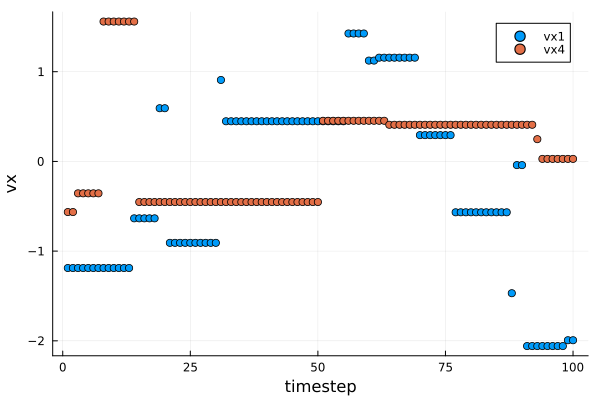

In [24]:
timestep=0.01
vs1=velocitytimeseries(sfull_N100_r01,timestep)
scatter([v[1] for v in vs1[1:100]],xlabel="timestep",ylabel="vx",label="vx1")
scatter!([v[4] for v in vs1[1:100]],xlabel="timestep",ylabel="vx",label="vx4")

In [49]:
eventanimate(sfull_N100_r01,0.001)

Task (runnable) @0x000000036a295aa0

In [25]:
length(vs1)

8703

Now, by hand we can look at the correlations.  We can just change the indices in this scatter plot to look at correlations in different time slices

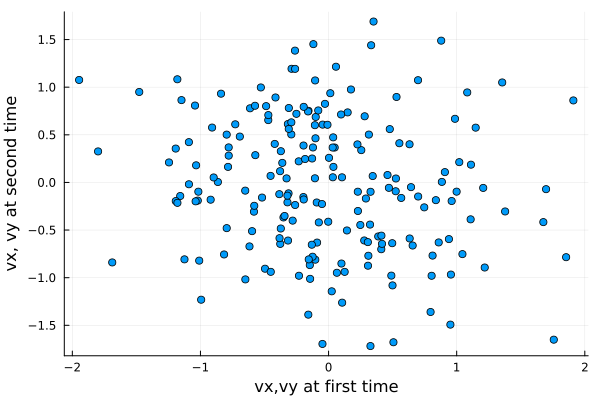

In [33]:
scatter(vs1[1000],vs1[2000],
    xlabel="vx,vy at first time",
    ylabel="vx, vy at second time",label="")

Initially the velocities are perfectly correlated, but for large time separations they appear random.

In [34]:
function autocorrelation(velocities,largestsep)
    timesteps=length(velocities)
    numv=length(velocities[1])
    [(velocities[1+j:end]⋅velocities[1:end-j])*2/(numv*(timesteps-j)) for j in 0:largestsep]
end

autocorrelation (generic function with 1 method)

In [69]:
length(vs1)

8703

In [68]:
vs1[1:end]⋅vs1[1:end]

870300.0

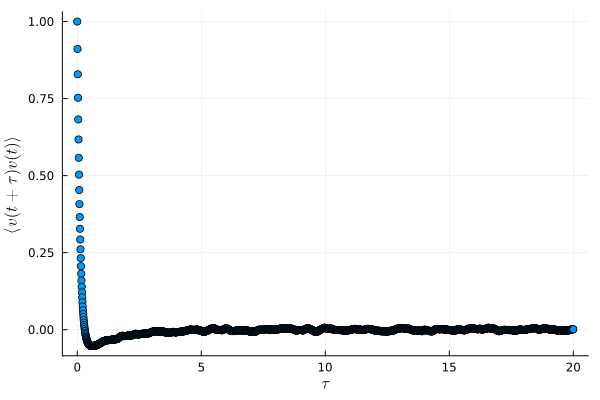

In [37]:
times=range(start=0.,length=2001,step=timestep)
scatter(times,autocorrelation(vs1,2000),label="",
    xlabel=L"$\tau$",ylabel=L"$\langle v(t+\tau)v(t)\rangle$")

That is kind of fun.  At short times the velocities are clearly correlated:  These correlations fall off on a timescale of order the collision rate.  Then there is a period during which the velocities are anti-correlated.  This makes sense, after you bounce off of another particle, you tend to be moving in the opposite direction from your start.  

<h2 style="color: red"> We are Here</h2>

The typical time between collsions is

In [ ]:
states1=sfull_N100_r01.statelist
finaltime=states1[end].t
initialtime=states1[1].t
numberofcollisions=length(states1)
numberofparticles=length(states1[1].xvalues)
meancollisiontime=(finaltime-initialtime)/(numberofcollisions/numberofparticles)

This is sometimes referred to as the `mean-free time`.  Lets scale our correlation function by the collision time, to give a scale to things

In [ ]:
scatter(times./meancollisiontime,autocorrelation(vs1,500),label="",
    xlabel=L"$\tau/\tau_c$",ylabel=L"$\langle v(t+\tau)v(t)\rangle$")

Finally, lets look at how the collision time changes with the radius of the spheres

In [ ]:
function collisiontime(;
        nx=10,ny=10,radius=0.01,Lx=1,Ly=1,
        equilibrationcollisions=1000,
        samplingcollisions=5000)
    b=randomgrid(nx,ny,radius,Lx,Ly)
    simulate(b,equilibrationcollisions)
    sim=simulate(b,samplingcollisions)
    states=sim.statelist
    finaltime=states[end].t
    initialtime=states[1].t
    numberofcollisions=length(states)
    numberofparticles=length(states[1].xvalues)
    meancollisiontime=(finaltime-initialtime)/(numberofcollisions/numberofparticles)
end

In [ ]:
@time collisiontime(radius=0.01)

If we do 50 radii it will take about 30 seconds

In [ ]:
radlist=collect(0.001:0.001:0.049)
@time taulist=[collisiontime(radius=r) for r in radlist]
scatter(radlist,taulist,xlabel="radius",ylabel="τ",label="")

Can we model this?  Well each particle is moving with an average speed $|v|=1$ in the units we are using.  If we think of a ball randomly moving, in time $dt$ will collide with anything other balls whose centers are within a strip that is $v\,dt$ long and $4 r$ wide.  Thus the number of collisions you expect in that time is $N_c= (v\,dt)(4 r)n$ where $n$ is the density of balls.  In this case $n=100$.  We find the collision time by setting $N_c=1$,

\begin{equation}
\tau \approx \frac{1}{4 r n v}= \frac{1}{400 r} 
\end{equation}

In [ ]:
tau_naive(r;density=100,vave=1)=1/(4*density*vave*r)
plot(tau_naive,0.001,0.05,label="")
scatter!(radlist,taulist,xlabel="radius",ylabel="τ",label="")
Plots.xlims!(0,0.05)

That is not bad -- but it seems to miss things at both small and large radii.  At small radii the discrepency is that we did not include collisions with the walls:

\begin{align}
\frac{1}{\tau} &= \frac{1}{\tau_b}+\frac{1}{\tau_w}\\
&= 400 r + 1
\end{align}

In [ ]:
tau_better(r)=1/(1+1/tau_naive(r)) #r->1/(1+400*r)
plot(tau_better,0.001,0.05,label="")
scatter!(radlist,taulist,xlabel="radius",ylabel="τ",label="")

Another nice trick here is to plot the rate instead of the time

In [ ]:
plot(x->1/tau_better(x),0.001,0.05,label="")
scatter!(radlist,1 ./taulist,xlabel="radius",ylabel="1/τ",label="")
Plots.ylims!(0,30)

Indeed, we seem to have captured what is happening at small radius.

The large radius discrepency has to do with the fact that in a time $dt$ the ball will actually be able to hit other balls which are in a region of area $A\sim(v dt+r)(4r)$.  So the average time to get a collision with another ball is
when 
\begin{align}
nA&=1\\
n(v dt+r)(4r)&=1\\
v dt+r&= \frac{1}{4n r}\\
dt &=\frac{1}{v} \left(
\frac{1}{4n r}-r
\right)
\end{align}

In [ ]:
tau_naive_improved(r;density=100,vave=1)=1/vave*(1/(4*density*vave*r)-r)
#r->1/(1+400*r/(1-400*r^2))
tau_improved(r)=1/(1+1/tau_naive_improved(r))
plot(tau_improved,0.001,0.05,label="")
scatter!(radlist,taulist,xlabel="radius",ylabel="τ",label="")
Plots.ylims!(0,0.2)

Interestingly, it appears that there is some radius at which $\tau\to0$.  This is the ``Jamming'' transition.

## Pressure

Another fun thing to look at is the pressure.  The most physical way to calculate pressure is to look at the collisions of the balls with the walls.  The pressure is the time averaged force exerted by these balls, normal to the wall, divided by the length of the wall.  The force is exerted in little impulses at each collsion.  So lets modify our simulation so that whenever there is a collision with the wall it stores the absolute value of the impulse.  The pressure is proportional to the sum these impulses divided by the time interval.

In [ ]:
function calculatepressure(billiard::Billiard,n)
    setevents!(billiard)
    startt=billiard.t
    momentum=0.
    for j in 2:n+1
        setevents!(billiard,billiard.nextevent)
        update!(billiard,billiard.nextevent)
        next=billiard.nextevent
        momentum+=wallmomentum(next.object1,next.object2)
    end
    endt=billiard.t
    return momentum/(endt-startt)
end

wallmomentum(b1::Ball,b2::Ball)=0
wallmomentum(hw::Hwall,b::Ball)=abs(2*b.vy)
wallmomentum(vw::Vwall,b::Ball)=abs(2*b.vx)
wallmomentum(b::Ball,w::Wall)=wallmomentum(w,b)

In [ ]:
p1=randomgrid(10,10,0.01,1,1)
@time calculatepressure(p1,1000) #equilibration run -- throw away
@time pressure1=calculatepressure(p1,5000)

In [ ]:
p2=randomgrid(10,10,0.048,1,1)
@time calculatepressure(p2,1000) #equilibration run -- throw away
@time pressure1=calculatepressure(p2,5000)

Apparently the pressure quite strongly depends on the ball radius!

In [ ]:
function pressure(rad)
    b=randomgrid(10,10,rad,1,1)
    calculatepressure(b,1000) # equilibrate
    calculatepressure(b,5000) # calculate pressure
end

In [ ]:
radlst=collect(0.01:0.001:0.049)
@time plst=[pressure(rad) for rad in radlst]
scatter(radlst,plst,xlabel="radius",ylabel="pressure",label="")

In [ ]:
scatter(radlst,1 ./plst,xlabel="radius",ylabel="1/P",label="")

Unfortunately, near the jamming transition the configurations can get stuck, and the result depends on the initial conditions.  For example, the `rad=0.049` data point is not indicative of a typical configuration

In [ ]:
p3=randomgrid(10,10,0.049,1,1)
s3=simulate(p3,5000)
visualize(p3)

when the radius is 0.048, however, it can rearange itself

In [ ]:
p4=randomgrid(10,10,0.048,1,1)
s4=simulate(p4,50000)
visualize(p4)

In [ ]:
eventanimate(s4)

There are tricks to avoid getting stuck, but fundamentally the system becomes "glassy" near the jamming transition -- and one needs to do very careful calculations.

It turns out that somewhere before things jam up the hard disk gas even has a "hexatic" phase transition, which is a precursor to forming a liquid.  We will not explore it.

## Spatial Correlations

If the Ergodic Hypothesis is correct, then every allowed configuration of hard spheres is equally likely.  That then uniquely specified the velocity distribution.  What does it tell us about the spatial distribution?

One challenge is how one even quantifies the spatial distribution.  One convenient question to ask is about the distribution of the separations between the particles: $g({\vec r})$ is the probability that 2 particles are separated by a vector $\vec{r}$.  This is referred to as the *pair distribution function*.  If you have rotational symmetry, one expects that $g$ will only depend on the magnitude of $r$, and it makes sense to average it over angles
\begin{equation}
g(r)=\frac{1}{2\pi}\int d\theta g({\vec r})
\end{equation}

We can measure $g(\vec{r})$ just like we did the speed distribution function -- we just record all of the separation between particles, and make a histogram.  As with the speeds, we can combine data from multiple times.  

One slightly confusing feature is that we can consider a different function $p(r)$ which is the probability that 2 particles are separated by distance $r$.
\begin{align}
p(r) &= \int d^2 \vec{s}\, g(\vec{s}) \delta(|\vec{s}|-r)\\
&= r g(r).
\end{align}
If we bin the occurences of separation $r$, we will have an estimate of $p(r)$.  Thus to get $g(r)$ we need to divide by $r$.

Rather than reporting back a big list of separations, it is better to bin the data as we go along.  Lets make a `Bin` object, which can be called with data, storing it in a array

In [ ]:
mutable struct Bin
    min ::Float64
    max ::Float64
    step ::Float64
    counts ::Array{Int64,1}
    under ::Int64
    over ::Int64
end

## Constructors

### Basic Constructor
function Bin(min,max,numbins)
    step=(max-min)/numbins
    counts=zeros(Int64,numbins)
    Bin(min,max,step,counts,0,0)
end

### Named Constructor -- allowing one to specify either numbins or step
function Bin(;min,max,numbins=0,step=0)
    if numbins==0 && step==0
        throw("Bin must be constructed with either `numbin` or `step` arguments")
    end
    if step==0
        return Bin(min,max,numbins)
    end
    numbins=Int64(round((max-min)/step))
    MAX=min+numbins*step
    return Bin(min,MAX,numbins)
end

function (b::Bin)(val)
    if val<b.min
        b.under+=1
        return b
    end
    if val>b.max
        b.over+=1
        return b
    end
    bnum=1+Int64(floor((val-b.min)/b.step))
    b.counts[bnum]+=1
    return b
end

Base.push!(b::Bin,val)=b(val)

function hist(b::Bin,opts...;norm=false,namedopts...)
    xvals=b.min:b.step:b.max
    total = sum(b.counts)
    scale=1
    if norm
        scale = total
    end
    bardata=[(xvals[j],b.counts[j]/scale) for j in 1:length(b.counts)]
    bar(bardata,opts...;namedopts...)
end

In [ ]:
tstbin=Bin(0.,10.,10)

In [ ]:
tstbin(6.6)

In [ ]:
tstbin(3.2)

In [ ]:
push!(tstbin,1.5)

In [ ]:
hist(tstbin)

Lets also make a N dimensional version.  

In [ ]:
mutable struct NBin{N,T}
    min ::NTuple{N,T}
    max ::NTuple{N,T}
    step ::NTuple{N,T}
    counts ::Array{Int64,N}
    under ::Int64
    over ::Int64
end

## Constructors
function NBin(min,max,numbins)
    step= @. (max-min)/numbins
    counts=zeros(Int64,Tuple(numbins))
    NBin(Tuple(min),Tuple(max),Tuple(step),counts,0,0)
end

function NBin(;min,max,numbins=[],step=[])
    if numbins==[] && step==[]
        throw("NBin must be constructed with either `numbins` or `step` arguments")
    end
    if step==[]
        return NBin(min,max,numbins)
    end
    numbins=@. Int64(round((max-min)/step))
    MAX=@. min+numbins*step
    NBin(Tuple(min),Tuple(MAX),Tuple(numbins))
end

function (b::NBin)(val)
    if any(Tuple(val).<b.min)
        b.under+=1
        return b
    end
    if any(Tuple(val).>b.max)
        b.over+=1
        return b
    end
    bnum=@. 1+Int64(floor((val-b.min)/b.step))
    b.counts[bnum...]+=1
    return b
end

Base.push!(b::NBin,val)=b(val)

function hist(b::NBin{1,T},opts...;norm=false,rscale=false,namedopts...) where {T}
    xvals=b.min[1]:b.step[1]:b.max[1]
    total = sum(b.counts)
    scale=1
    if norm
        scale = total
    end
    bardata=[(xvals[j],b.counts[j]/scale) 
            for j in 1:length(b.counts)]
    if rscale
        bardata=[(xvals[j],b.counts[j]/(scale*xvals[j])) 
                for j in 2:length(b.counts)]
    end
    bar(bardata,opts...;namedopts...)
end

function hist(b::NBin{2,T},opts...;norm=false,namedopts...) where {T}
    total = sum(b.counts)
    scale=1
    if norm
        scale = total
    end
    xvalues=collect(b.min[1]:b.step[1]:b.max[1])
    yvalues=collect(b.min[2]:b.step[2]:b.max[2])
    heatmap(xvalues,yvalues,b.counts./scale,opts...;namedopts...)
end

In [ ]:
tstbin2=NBin([0.,0.],[1.,1.],[10,10])
data=[(rand(),rand()) for j in 1:100]
for d in data
    push!(tstbin2,d)
end
tstbin2

In [ ]:
hist(tstbin2,norm=true,aspect_ratio=:equal)

Now lets step through the simulation data, sampling the separations at each timestep:

In [ ]:
function correlationtimeseries(s::Simulationdata;
        dt,dx,dy,dr,xmin=-1/2,xmax=1/2,ymin=-1/2,ymax=1/2,
        rmin=0.,rmax=1.)
    # set up data structures
    states=s.statelist
    t=states[1].t
    v_sep=NBin(min=(xmin,ymin),max=(xmax,ymax),step=(dx,dy))
    s_sep=NBin(min=rmin,max=rmax,step=dr)
    # step through collisions
    for j in 2:length(states)
        tj=states[j].t
        # if collision is more than dt in the future
        # then we want to sample the velocities,
        # and increment t.
        #
        # We use a while loop, as we the next 
        # collision might be multiple dt's in the future
        #
        # We want to "eat up" all those timesteps 
        # before incrementing to the next collision
        while tj>t+dt  
            t+=dt
            prev=states[j-1]
            nxt=states[j]
            rbin!(v_sep,s_sep,prev,nxt,t)
        end
    end
    return (v_sep=v_sep,s_sep=s_sep)
end

function rbin!(v_sep,s_sep,prev,nxt,t)
    # Find positions at intermediate time
    prevt=prev.t
    nxtt=nxt.t
    prevweight=(nxtt-t)/(nxtt-prevt)
    nxtweight=(t-prevt)/(nxtt-prevt)
    xvals=@. prev.xvalues*prevweight+nxt.xvalues*nxtweight
    yvals=@. prev.yvalues*prevweight+nxt.yvalues*nxtweight
    len=length(xvals)
    dif=[0.,0.]
    for j in 1:(len-1)
        for i in j+1:len
            dif .= (xvals[i]-xvals[j],yvals[i]-yvals[j])
            v_sep(dif)
            v_sep(-dif)
            s_sep(norm(dif))
        end
    end
    return nothing
end
    

In [ ]:
p1=randomgrid(10,10,0.01,1,1)
s1=simulate(p1,10000) #equilibrate
@time s1=simulate(p1,50000)
@time cs1=correlationtimeseries(s1,dt=0.5,dx=0.01,dy=0.01,dr=0.01,
    xmin=-1.,ymin=-1.,xmax=1.,ymax=1.);

Since the x and y coordinates of each particle are bounded, the histogram of separations falls off with distance.  This is solely a finite system size artifact.  Also, rotational symmetry is broken by the walls.

In [ ]:
hist(cs1.v_sep,norm=false,aspect_ratio=:equal,xlabel="x",ylabel="y")

Here is now a raw histogram of the separations between particles.

In [ ]:
hist(cs1.s_sep,norm=false,rscale=false,
    label="",xlabel="r",ylabel="Number of particles separated by r")

In [ ]:
hist(cs1.s_sep,norm=true,rscale=false,label="",xlabel="r",ylabel="p(r)")

As already discussed, it makes sense to divide the vertical axis by $r$, so we get the average number of particles at distance $r$ in any one direction, $g(r)$,

In [ ]:
hist(cs1.s_sep,norm=false,rscale=true,label="",
    xlabel="r",ylabel="g(r)")

In the thermodynamic limit that graph should be flat -- but again, due to finite system size, there are fewer particles at large distances.

Now lets increase the size of the particles

In [ ]:
p2=randomgrid(10,10,0.03,1,1)
s2=simulate(p2,10000) #equilibrate
@time s2=simulate(p2,50000)
@time cs2=correlationtimeseries(s2,dt=0.1,dx=0.01,dy=0.01,dr=0.01);

In [ ]:
eventanimate(s2)

In [ ]:
hist(cs2.s_sep,norm=true,rscale=true,label="",xlabel="r",ylabel="g(r)")

The new thing that we are seeing is that there is a peak in $g(r)$ at the particle radius, and a dip at roughly twice the particle radius.  That means particles are more likely to have certain spacings.  Lets see what that looks like in 2D

In [ ]:
hist(cs2.v_sep,norm=false,aspect_ratio=:equal,xlim=[-0.2,0.2],ylim=[-0.2,0.2])

If we want more resolution we can average more frames, by making `dt` smaller, and take a smaller spacial grid

In [ ]:
@time cs2hr=correlationtimeseries(s2,dt=0.01,dx=0.005,dy=0.005,dr=0.001);

In [ ]:
hist(cs2hr.v_sep,norm=false,aspect_ratio=:equal,xlim=[-0.2,0.2],ylim=[-0.2,0.2])

Things become even more interesting when we make the particle size larger yet

In [ ]:
p3=randomgrid(10,10,0.04,1,1)
s3=simulate(p3,10000) #equilibrate
@time s3=simulate(p3,50000)
@time cs3=correlationtimeseries(s3,dt=0.1,dx=0.01,dy=0.01,dr=0.01);

In [ ]:
hist(cs3.s_sep,norm=true,rscale=true,label="",xlabel="r",ylabel="g(r)")

We now have multiple bumps.  This is characteristic of a liquid.  The particles are roughly evenly spaced, so you are more likely to see particles at multiples of that spacing:

In [ ]:
visualize(p3)

In [ ]:
eventanimate(s3)

In [ ]:
hist(cs3.v_sep,norm=false,aspect_ratio=:equal)

Another very clear feature is the horizontal and vertical bands in that correlation funciton plot.  These are due to the boundaries.  Just as particles are more likely to be found touching eachother, they are more likely to be found touching the walls.

Lets now make the radius even bigger

In [ ]:
p4=randomgrid(10,10,0.048,1,1)
s4=simulate(p4,10000) #equilibrate
@time s4=simulate(p4,50000)
@time cs4=correlationtimeseries(s4,dt=0.01,dx=0.005,dy=0.005,dr=0.001);

In [ ]:
hist(cs4.s_sep,norm=true,rscale=true)

In [ ]:
eventanimate(s4)

We now have a more complicated sequence of bumps.  These are related to some sort of spatial ordering:

In [ ]:
hist(cs4.v_sep,norm=true,aspect_ratio=:equal)

Here we have very distinct breaking of rotational symmetry.  This is the sort of thing you tend to see in solids.  If you look at the snapshots of the motion, you see definite "crystaline" regions.

In [ ]:
visualize(p4)

### Pair distribution function as a correlation function

It is useful to connect the  pair distribution function to a slightly more abstract quantity -- the two particle correlation function.  We make this connection to introduce the idea of correlation functions, and how they are probes of the physical system.

We first note that the probability of finding a particle at position $\vec{r}$ can be written as an expectation value:
\begin{equation}
P_1(\vec{r}) =\langle\sum_j \delta(\vec r_j-\vec r) \rangle
\end{equation}
where $\vec r_j$ is the position of the $j$'th particle.  This expectation value can mean taking the average over many frames of our simulation.  Note that $P_1(\vec{r})$ can also be interpreted as the density of particles at $\vec{r}$.  We can write a single realization of the density as
\begin{equation}
n(\vec{r})=\sum_j \delta(\vec r_j-\vec r)
\end{equation}
and the ensemble average as
\begin{equation}
\langle n(\vec{r})\rangle = \langle\sum_j \delta(\vec r_j-\vec r) \rangle.
\end{equation}

Similarly, our pair distribution function can be written as
\begin{align}
g(\vec{r})&= \int d^2 \vec{r}_1\, \langle n(r_1)n(r_1+\vec{r})\rangle
\end{align}
It is telling us how correlated the density is at points separated by a displacement $\vec{r}$.